## Car with Obstacles

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra

Import the car model

In [2]:
model = Dynamics.car
model_d = rk3(model)
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [3]:
T = Float64;

Define initial and goals states

In [4]:
x0 = [0.; 0.; 0.]
xf = [1.; 1.; 0.]

3-element Array{Float64,1}:
 1.0
 1.0
 0.0

Define a cost function, e.g., quadratic

In [5]:
Q = (1.0e-2)*Diagonal(I,n)
R = (1.0)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)

3×3 Diagonal{Float64,Array{Float64,1}}:
 1000.0      ⋅       ⋅ 
     ⋅   1000.0      ⋅ 
     ⋅       ⋅   1000.0

Define obstacles

In [9]:
# create obstacle constraints
r_circle = 0.1
circles = ((0.4,0.25,r_circle),(0.8,0.65,r_circle),(1.0,0.85,r_circle))
n_circles = length(circles)

function circle_obs(c,x,u)
    for i = 1:n_circles
        c[i] = TrajectoryOptimization.circle_constraint(x,circles[i][1],circles[i][2],circles[i][3])
    end
    return nothing
end

obs = Constraint{Inequality}(circle_obs,n,m,n_circles,:obs);
goal = goal_constraint(xf);

Define a problem

In [10]:
N = 101 # number of knot points
dt = 0.1 # total time

U = [rand(m) for k = 1:N-1] 

obj = LQRObjective(Q,R,Qf,xf,N) # objective with same stagewise costs
constraints = Constraints(N) # constraints at each stage
for k = 1:N-1
    constraints[k] += obs
end
constraints[N] += goal
    
prob = Problem(model_d,obj, constraints=constraints, x0=x0, xf=xf, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

Solve problem

In [11]:
solve!(prob, ALTROSolverOptions{T}(verbose=true)) # solve with iLQR

┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24


TrajectoryOptimization.ALTROSolver{Float64}(ALTROSolverOptions{Float64}
  verbose: Bool true
  opts_al: AugmentedLagrangianSolverOptions{Float64}
  constraint_tolerance_infeasible: Float64 1.0e-5
  R_inf: Float64 1.0
  dynamically_feasible_projection: Bool true
  resolve_feasible_problem: Bool true
  penalty_initial_infeasible: Float64 1.0
  penalty_scaling_infeasible: Float64 10.0
  R_minimum_time: Float64 1.0
  dt_max: Float64 1.0
  dt_min: Float64 0.001
  penalty_initial_minimum_time_inequality: Float64 1.0
  penalty_initial_minimum_time_equality: Float64 1.0
  penalty_scaling_minimum_time_inequality: Float64 1.0
  penalty_scaling_minimum_time_equality: Float64 1.0
  projected_newton: Bool false
  opts_pn: ProjectedNewtonSolverOptions{Float64}
  projected_newton_tolerance: Float64 0.001
, Dict{Symbol,Any}(:time_pn=>0.0085299,:time_al=>12.8922,:time=>16.8056), AugmentedLagrangianSolver{Float64}(AugmentedLagrangianSolverOptions{Float64}
  verbose: Bool false
  opts_uncon: iLQRSolverOp

In [12]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

101-element Array{Float64,1}:
  0.0                   
 -0.00015620310634572478
 -0.0005736451504422751 
 -0.0011821170900790418 
 -0.0019064370078865768 
 -0.0026673917922812405 
 -0.003382773259220216  
 -0.003968486922061166  
 -0.00433970840288843   
 -0.004412060240847195  
 -0.004102780742124108  
 -0.003331856612824033  
 -0.002023092422976043  
  ⋮                     
  1.0017933945854076    
  1.0022296701653386    
  1.0023997335261583    
  1.0023509533413455    
  1.0021314375559194    
  1.001789616840193     
  1.0013738262532215    
  1.0009318915254364    
  1.000510724826304     
  1.0001559323161668    
  0.999911436403178     
  0.9998191257460538    

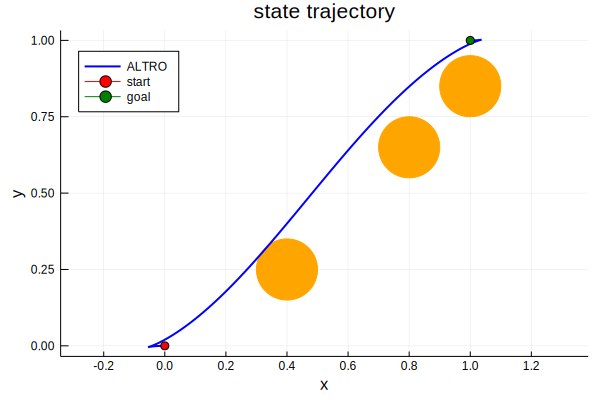

In [13]:
plot()
plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:topleft,color=:blue,width=2,ratio=:equal,title="state trajectory")
plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

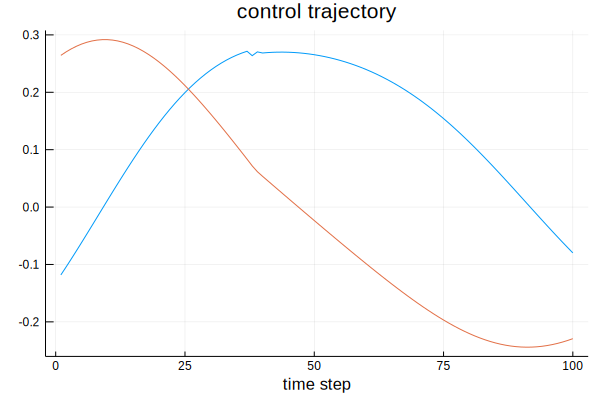

In [14]:
plot(prob.U,xlabel="time step",legend=:none,title="control trajectory")